In [1]:
%matplotlib notebook

# Standard library imports
import logging

# Third party imports
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp 
from numpy.linalg import multi_dot, norm
from toolz import concat, first
import matplotlib.pyplot as plt
from matplotlib import animation
#from toolz import concat

# Local application imports
#from myorbit.graphics_util import OrbitsPlot, calc_interval
#import myorbit.data_catalog as dc
#from myorbit.scripts import calc_orbits_heliocentric_data, change_reference_frame
#from myorbit.ephemeris_input import EphemrisInput

%load_ext autoreload
%autoreload 2

### Initial value problem
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

In [2]:
class OrbitPlotter2D:
    def __init__(self, orbs_data, x_axlimits, y_axlimits, t_refs) :
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, aspect='equal', autoscale_on=False)        
        self.orbs = orbs_data        
        self.n_trajectories = len(self.orbs)
        self.t_refs = t_refs
        
        self.ax.set_xlabel('x')
        self.ax.set_ylabel('y')
        #ax.axis('off')
        
        # prepare the axes limits
        self.ax.set_xlim(x_axlimits)
        self.ax.set_ylim(y_axlimits)
        
        self.ax.set_xlabel("X")
        self.ax.set_ylabel("Y")        
        
        n_trajectories = len(self.orbs)

        # choose a different color for each trajectory
        colors = plt.cm.jet(np.linspace(0, 1, n_trajectories))

        # lines and points initializaiton
                
        lines = []
        pts = []
        for i, (name, mtx) in enumerate(orbs.items()):
            lines.append(self.ax.plot([], [], '--', c=colors[i], label=name,lw=.7))
            pts.append(self.ax.plot([], [], 'o', c=colors[i]))
        self.lines = list(concat(lines))
        self.pts = list(concat(pts))

        # set the legend, title and animation encoding type
        self.ax.legend(loc='upper right', prop={'size': 9})

        axtext = self.fig.add_axes([0.0,0.95,0.1,0.05])
        # turn the axis labels/spines/ticks off
        axtext.axis("off")

        self.time_obj = axtext.text(0.5,0.5, sol.t[0], ha="left", va="top")        

    # initialization function: plot the background of each frame
    def init(self):
        for line, pt in zip(self.lines, self.pts):
            line.set_data([], [])
            pt.set_data([], [])
        return lines + pts

    def animate(self, i):
        for line, pt, mtx in zip(self.lines, self.pts, self.orbs.values()):
            xs = mtx[0:i,0]        
            ys = mtx[0:i,1]
            line.set_data(xs, ys)
            x = xs[-1:]
            y = ys[-1:]
            pt.set_data(x, y)
            self.time_obj.set_text(self.t_refs[i])
        #ax.view_init(30, 0.3 * i)
        self.time_obj.set_text(self.t_refs[i])
        return self.lines + self.pts       
    
    def start(self,interval=1000, blit=False, repeat=False):
        self.anim = animation.FuncAnimation(self.fig, self.animate, frames=len(self.t_refs), interval=interval, blit=blit, repeat=repeat)

In [6]:
class OrbitPlotter3D:
    #t_refs= sol.t[i]

    def __init__(self, orbs_data, x_axlimits, y_axlimits, t_refs) :
        self.fig = plt.figure()
        self.ax = self.fig.add_axes([0, 0, 1, 1], projection='3d')
        self.orbs = orbs_data        
        self.n_trajectories = len(self.orbs)
        self.t_refs = t_refs
        
        self.ax.set_xlabel('x')
        self.ax.set_ylabel('y')
        self.ax.set_zlabel('z')
        #ax.axis('off')
        
        # prepare the axes limits
        self.ax.set_xlim(x_axlimits)
        self.ax.set_ylim(y_axlimits)
        self.ax.set_zlim(y_axlimits)
        
        self.ax.set_xlabel("X")
        self.ax.set_ylabel("Y")        
        
        n_trajectories = len(self.orbs)

        # choose a different color for each trajectory
        colors = plt.cm.jet(np.linspace(0, 1, n_trajectories))

        # lines and points initializaiton
                
        lines = []
        pts = []
        for i, (name, mtx) in enumerate(orbs.items()):
            lines.append(self.ax.plot([], [], '--', c=colors[i], label=name,lw=.7))
            pts.append(self.ax.plot([], [], 'o', c=colors[i]))
        self.lines = list(concat(lines))
        self.pts = list(concat(pts))

        # set the legend, title and animation encoding type
        self.ax.legend(loc='upper right', prop={'size': 9})

        axtext = self.fig.add_axes([0.0,0.95,0.1,0.05])
        # turn the axis labels/spines/ticks off
        axtext.axis("off")

        self.time_obj = axtext.text(0.5,0.5, sol.t[0], ha="left", va="top")        

    # initialization function: plot the background of each frame
    def init(self):        
        for line, pt in zip(self.lines, self.pts):
            line.set_data([], [])
            line.set_3d_properties([])
            pt.set_data([], [])
            pt.set_3d_properties([])
        return self.lines + self.pts    
    

    def animate(self, i):
        for line, pt, mtx in zip(self.lines, self.pts, self.orbs.values()):
                    xs = mtx[0:i,0]        
                    ys = mtx[0:i,1]
                    zs = mtx[0:i,2]
                    line.set_data(xs, ys)
                    line.set_3d_properties(zs)
                    x = xs[-1:]
                    y = ys[-1:]
                    z = zs[-1:]        
                    pt.set_data(x, y)
                    pt.set_3d_properties(z)
        self.time_obj.set_text(self.t_refs[i])
        return self.lines + self.pts
    
    def start(self,interval=1000, blit=False, repeat=False):
        self.anim = animation.FuncAnimation(self.fig, self.animate, frames=len(self.t_refs), interval=interval, blit=blit, repeat=repeat)

In [7]:
# Two bodys 
G = 6.6742e-20 # Km^3/Kg*s^2
m1 = m2 = 1e26
#m2 = 1e10
# Initial position and velocity vectors of m1
r0_xyz_m1 = np.array([0,0,0])
v0_xyz_m1 = np.array([10,20,30])
# Initial position and velocity vectors of m2
r0_xyz_m2 = np.array([3000,0,0])
v0_xyz_m2 = np.array([0,40,0])
Y0 = np.concatenate((r0_xyz_m1, r0_xyz_m2, v0_xyz_m1, v0_xyz_m2))
t0 = 0
tf = 480

def my_dfdt(t, Y, G, m1, m2):     
    """ Y is the state vector
    my_dfdt is the time derivative of the state vector (r_xyz,v_xyz) which can be expressed as a function of the
    the state vector and the time since the aceleration can be expressed as function of the r(t), i.e.,
    as function of the state vector.
    
    Parameters
    ----------
    t : [type]
        [description]
    Y : [type]
        [description]
    G : [type]
        [description]
    m1 : [type]
        [description]
    m2 : [type]
        [description]

    Returns
    -------
    [type]
        [description]    
    """
    r1_xyz = Y[0:3]
    r2_xyz = Y[3:6]
    v1_xyz = Y[6:9]
    v2_xyz = Y[9:12]
    r_3  = np.linalg.norm(r2_xyz-r1_xyz)**3
    acc1_xyz = G*m2*(r2_xyz - r1_xyz)/r_3
    acc2_xyz = G*m1*(r1_xyz - r2_xyz)/r_3
    return np.concatenate((v1_xyz, v2_xyz, acc1_xyz, acc2_xyz))

sol = solve_ivp(my_dfdt, (t0, tf), Y0, args=(G,m1,m2), t_eval=list(range(0,480,4)), rtol = 1e-5)  
print (sol.y.shape)

(12, 120)


<IPython.core.display.Javascript object>


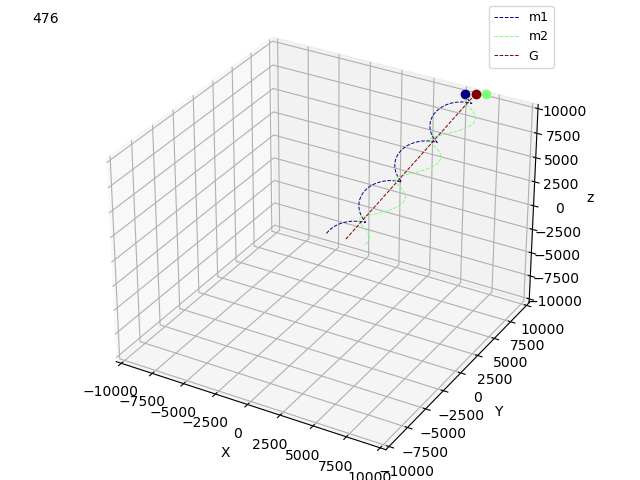

In [8]:
# Two equivalent bodys w.r.t an inertial frame of reference
orbs={}
orbs['m1'] = sol.y[0:3,:].T
orbs['m2'] = sol.y[3:6,:].T
orbs['G'] =  (m1*orbs['m1']+m2*orbs['m2'])/(m1+m2)

x_limits = (-10000,10000)
y_limits = (-10000,10000)
plotter = OrbitPlotter3D(orbs, x_limits, y_limits, sol.t)
plotter.start(interval=250)
plt.show()

In [41]:
# The mass centre is not accelerated (first order differents, the velocity, is constant ,i.e. no accelaration)
np.diff(orbs['G'],n=1, axis=0)

array([[ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
       [ 20., 120.,  60.],
 

In [42]:
# M1 is accelerated (of course) (first order differences, the velocity, is NOT constant, i.e. there is acceleration)
np.diff(orbs['m1'],n=1, axis=0)

array([[  45.99041256,   80.05392227,  119.91911659],
       [  58.24536439,   80.38930241,  119.41604638],
       [  71.01829828,   81.10192454,  118.34711319],
       [  84.47567353,   82.260015  ,  116.6099775 ],
       [  98.82467312,   83.96813273,  114.04780091],
       [ 114.33194499,   86.3844548 ,  110.4233178 ],
       [ 131.35245089,   89.76115009,  105.35827486],
       [ 150.3697924 ,   94.50435897,   98.24346155],
       [ 172.06141249,  101.33174217,   88.00238674],
       [ 197.35535824,  111.58868297,   72.61697554],
       [ 227.34083815,  128.14097134,   47.78854299],
       [ 261.62579502,  158.10454208,    2.84318688],
       [ 281.77816611,  221.78598438,  -92.67897657],
       [ 137.44047881,  328.84926929, -253.27390394],
       [-148.77498743,  295.49336601, -203.24004902],
       [-204.54329976,  210.63482881,  -75.95224322],
       [-188.76605956,  166.43335217,   -9.65002826],
       [-165.99383211,  141.76174718,   27.35737923],
       [-144.55150183,  126.

In [34]:
np.diff(orbs['G'],axis=0)

array([[ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
       [ 40.,  80., 120.],
 

<IPython.core.display.Javascript object>


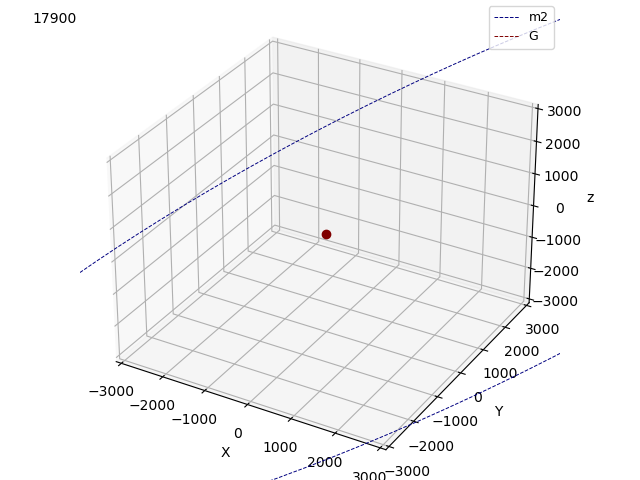

In [7]:
# Two equivalent bodys w.r.t m1
orbs={}
orbs['m1'] = sol.y[0:3,:].T
orbs['m2'] = sol.y[3:6,:].T
orbs['G'] =  (m1*orbs['m1']+m2*orbs['m2'])/(m1+m2)

# With respect m1

orbs['m2'] =  orbs['m2']  - orbs['m1'] 
orbs['G']  =  orbs['G']  - orbs['m1']
orbs.pop('m1','')


x_limits = (-3000,3000)
y_limits = (-3000,3000)
plotter = OrbitPlotter3D(orbs, x_limits, y_limits, sol.t)
plotter.start(interval=250)
plt.show()

<IPython.core.display.Javascript object>


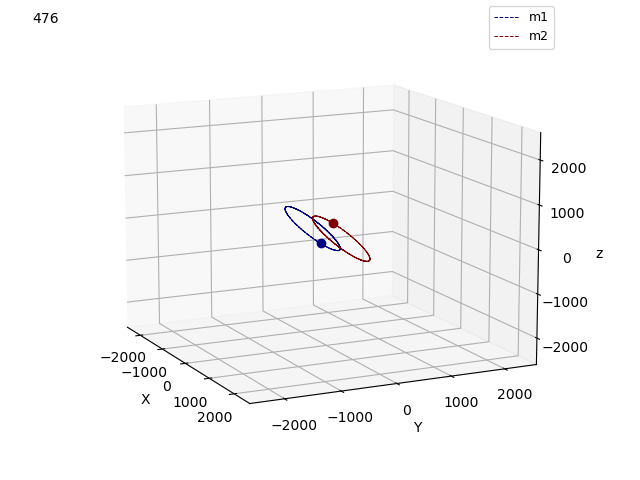

In [10]:
# Two equivalent bodys w.r.t G (mass centre)
orbs={}
orbs['m1'] = sol.y[0:3,:].T
orbs['m2'] = sol.y[3:6,:].T
orbs['G'] =  (m1*orbs['m1']+m2*orbs['m2'])/(m1+m2)

# With respect G
orbs['m1'] =  orbs['m1']  - orbs['G'] 
orbs['m2'] =  orbs['m2']  - orbs['G'] 
#orbs['G'] =  orbs['G']  - orbs['G'] 
orbs.pop('G','')


x_limits = (-2500,2500)
y_limits = (-2500,2500)
plotter = OrbitPlotter3D(orbs, x_limits, y_limits, sol.t)
plotter.start(interval=250)
plt.show()

In [16]:
ref_v = np.array([-1500,0,0])
for idx, v in enumerate(orbs['m1']):
    print (idx,v,np.linalg.norm(ref_v-v))

0 [-1500.     0.     0.] 0.0
1 [-1474.00958744   -39.94607773    59.91911659] 76.56037619809966
2 [-1435.76422305   -79.55677532   119.33516297] 157.1508722900518
3 [-1384.74592477  -118.45485078   177.68227617] 242.66446957604364
4 [-1320.27025124  -156.19483578   234.29225367] 334.05459051786573
5 [-1241.44557812  -192.22670305   288.34005458] 432.3672993142749
6 [-1147.11363313  -225.84224825   338.76337237] 538.789505724447
7 [-1035.76118225  -256.08109816   384.12164723] 654.7095910527338
8 [-905.39138985 -281.57673919  422.36510878] 781.8165669993107
9 [-753.32997735 -300.24499702  450.36749552] 922.2223495325069
10 [-575.97461911 -308.65631405  462.98447107] 1078.6316540764494
11 [-368.63378096 -300.5153427   450.77301406] 1254.3904109135747
12 [-127.00798594 -262.41080062  393.61620093] 1452.2052928580679
13 [ 134.77018017 -160.62481625  240.93722437] 1660.2182445885558
14 [252.21065899  48.22445305 -72.33667957] 1754.3660925113065
15 [  83.43567156  223.71781906 -335.57672859]

(120, 3)

In [5]:
# Two bodys, m1 is very big and m2 is small with relative acceleration
G = 6.6742e-20 # Km^3/Kg*s^2
m1 = 5.974e24
R =  6378
m2 = 1000
r0_xyz= np.array([8000,0,6000])
v0_xyz = np.array([0, 7, 0])
t0 = 0 
tf = 5*3600
Y0 = np.concatenate((r0_xyz, v0_xyz))

def my_dfdt(t, Y, G, m1, m2):        
    x = Y[0:3]
    v = Y[3:6]
    r_3  = np.linalg.norm(x)**3
    mu = G*(m1+m2)
    acc = -mu/r_3*x    
    return np.concatenate((v, acc))

sol = solve_ivp(my_dfdt, (t0, tf), Y0, args=(G,m1,m2), t_eval=list(range(t0,tf,100)), rtol = 1e-10)  
print (sol.y.shape)

(6, 180)


<IPython.core.display.Javascript object>


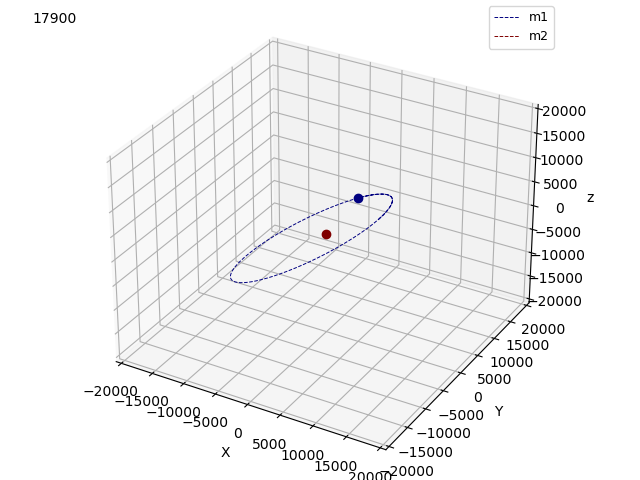

In [6]:
orbs={}
orbs['m1'] = sol.y[0:3,:].T
orbs['m2'] = orbs['m1'] - orbs['m1']
x_limits = (-20000,20000)
y_limits = (-20000,20000)
plotter = OrbitPlotter3D(orbs, x_limits, y_limits, sol.t)
plotter.start(interval=250)
plt.show()

In [31]:
# Three equivalent bodys
G = 6.6742e-20 # Km^3/Kg*s^2
m1 = m2 = m3 = 1e29
m2 = 6349
x1 = np.array([0,0])
x2 = np.array([300000,0])
x3 = 2*x2

v1 = np.array([0,0])
v2 = np.array([250,250])
v3 = np.array([0,0])

t0 = 0 
tf = 67000
Y0 = np.concatenate((x1, x2, x3, v1, v2, v3))


def my_dfdt(t, Y, G, m1, m2, m3):
    x1 = Y[0:2]
    x2 = Y[2:4]
    x3 = Y[4:6]
    
    v1 = Y[6:8]
    v2 = Y[8:10]
    v3 = Y[10:12]
    
    r12__3 = np.linalg.norm(x1-x2)**3
    r23__3 = np.linalg.norm(x2-x3)**3
    r13__3 = np.linalg.norm(x1-x3)**3
    
    a1 = G*((m2*(x2-x1)/r12__3) + (m3*(x3-x1)/r13__3))
    a2 = G*((m1*(x1-x2)/r12__3) + (m3*(x3-x2)/r23__3))
    a3 = G*((m1*(x1-x3)/r13__3) + (m2*(x2-x3)/r23__3))
    
    return np.concatenate((v1,v2,v3,a1,a2,a3))
    
sol = solve_ivp(my_dfdt, (t0, tf), Y0, args=(G,m1,m2,m3), t_eval=list(range(t0,tf,1000)), rtol = 1e-10)  
    

<IPython.core.display.Javascript object>


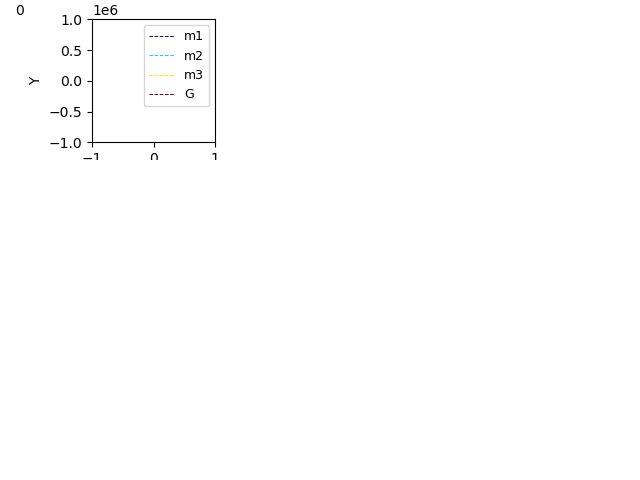

In [33]:
# Here the r's and v's have only 2 dimensions
# Three bodys w.r.t the mass centre
orbs={}
orbs['m1'] = sol.y[:2,:].T
orbs['m2'] = sol.y[2:4,:].T
orbs['m3'] = sol.y[4:6,:].T
orbs['G'] =  (m1*orbs['m1']+m2*orbs['m2']+m3*orbs['m3'])/(m1+m2+m3)

# With respect G
orbs['m1'] =  orbs['m1']  - orbs['G']
orbs['m2'] =  orbs['m2']  - orbs['G'] 
orbs['m3'] =  orbs['m3']  - orbs['G'] 
orbs['G']  =  orbs['G']  - orbs['G']

x_limits = (-1000000,1000000)
y_limits = (-1000000,1000000)
plotter = OrbitPlotter2D(orbs, x_limits, y_limits, sol.t)
plotter.start(interval=250)
plt.show()

<IPython.core.display.Javascript object>


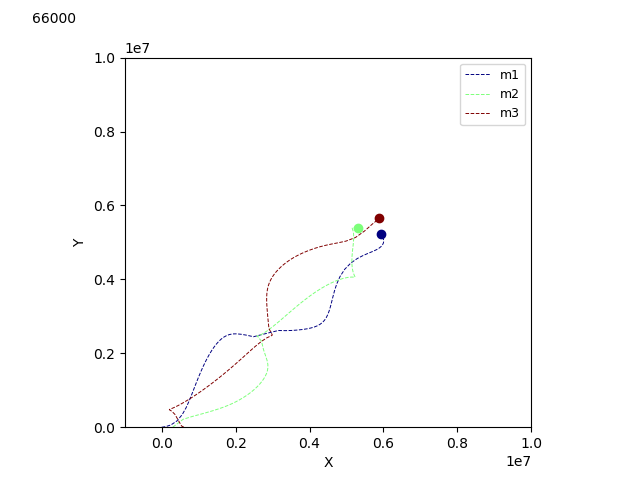

In [162]:
# Here the r's and v's have only 2 dimensions
# Three bodys w.r.t an inertial frame of reference
orbs={}
orbs['m1'] = sol.y[:2,:].T
orbs['m2'] = sol.y[2:4,:].T
orbs['m3'] = sol.y[4:6,:].T

x_limits = (-1000000,10000000)
y_limits = (0,10000000)
plotter = OrbitPlotter(orbs, x_limits, y_limits, sol.t)
plotter.start(interval=250)
plt.show()

In [177]:
# Lagrange Points

MT=5.98e24 
ML=7.349e22
alpha=ML/(ML+MT)

start, stop, n_values = -1.5, 1.5, 60
x_vals = np.linspace(start, stop, n_values)
y_vals = np.linspace(start, stop, n_values)
X, Y = np.meshgrid(x_vals, y_vals)

Z1 = (1-alpha)/np.sqrt(np.power(X+alpha,2)+np.power(Y,2))
Z2 = alpha/np.sqrt(np.power(X-1+alpha,2)+np.power(Y,2))
Z3 = 0.5*(np.power(X,2)+np.power(Y,2))
Z = -Z1-Z2-Z3
print (Z.min(), Z.max())

-34.45100713092601 -1.4940450963664158


In [186]:
levels

array([-2.5       , -2.33333333, -2.16666667, -2.        , -1.83333333,
       -1.66666667, -1.5       , -1.33333333, -1.16666667, -1.        ])

<IPython.core.display.Javascript object>


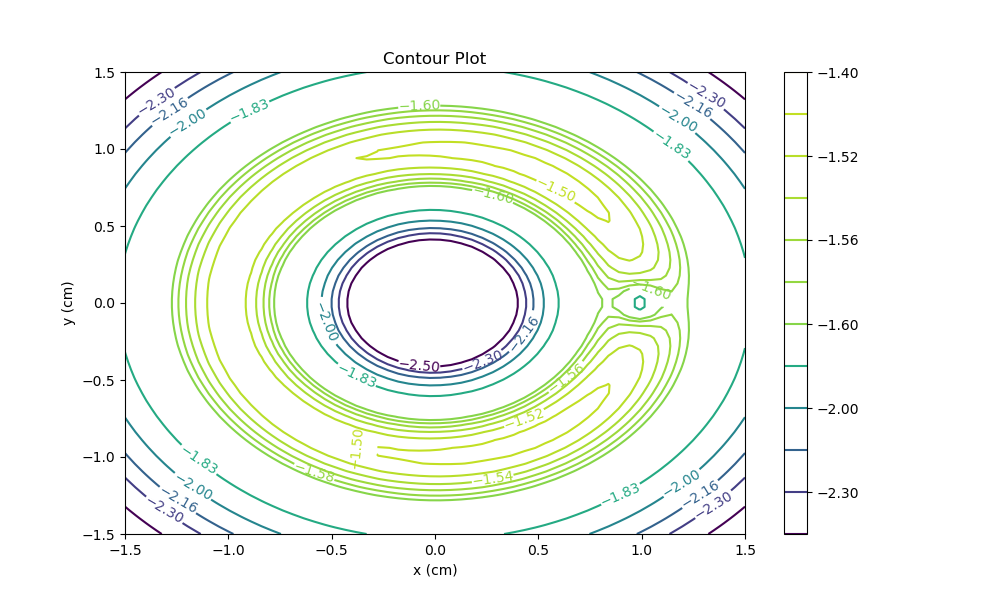

In [200]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"]=(10,6)

fig, ax = plt.subplots()
levels = np.linspace(-2.5, -1, 10)
levels = np.array([-2.5, -2.3, -2.16, -2, -1.83, -1.6, -1.58, -1.56, -1.54, -1.52,  -1.5, -1.4])       
cp = ax.contour(X, Y, Z, levels)
ax.clabel(cp, inline=True, fontsize=10)
ax.set_title('Simplest default with labels')
plt.colorbar(cp)

ax.set_title('Contour Plot')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [175]:
Z.min()

-15.472754149917076

<IPython.core.display.Javascript object>


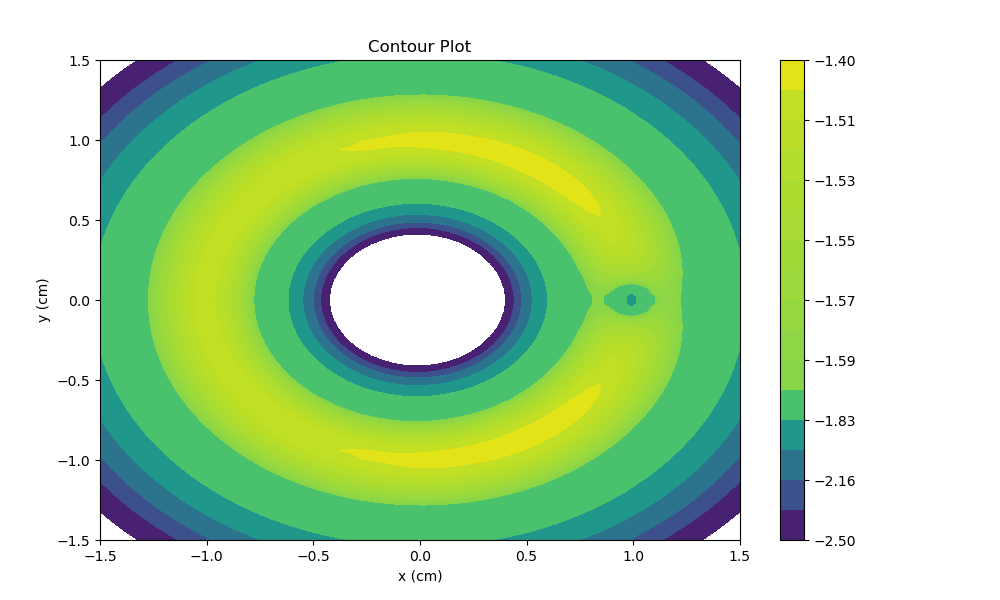

In [203]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,6))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

levels = np.array([-2.5, -2.3, -2.16, -2, -1.83, -1.6, -1.59, -1.58, -1.57, -1.56, -1.55, -1.54, -1.53, -1.52, -1.51, -1.5, -1.4])       
cp = plt.contourf(X, Y, Z, levels)
plt.colorbar(cp)

ax.set_title('Contour Plot')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()



<IPython.core.display.Javascript object>


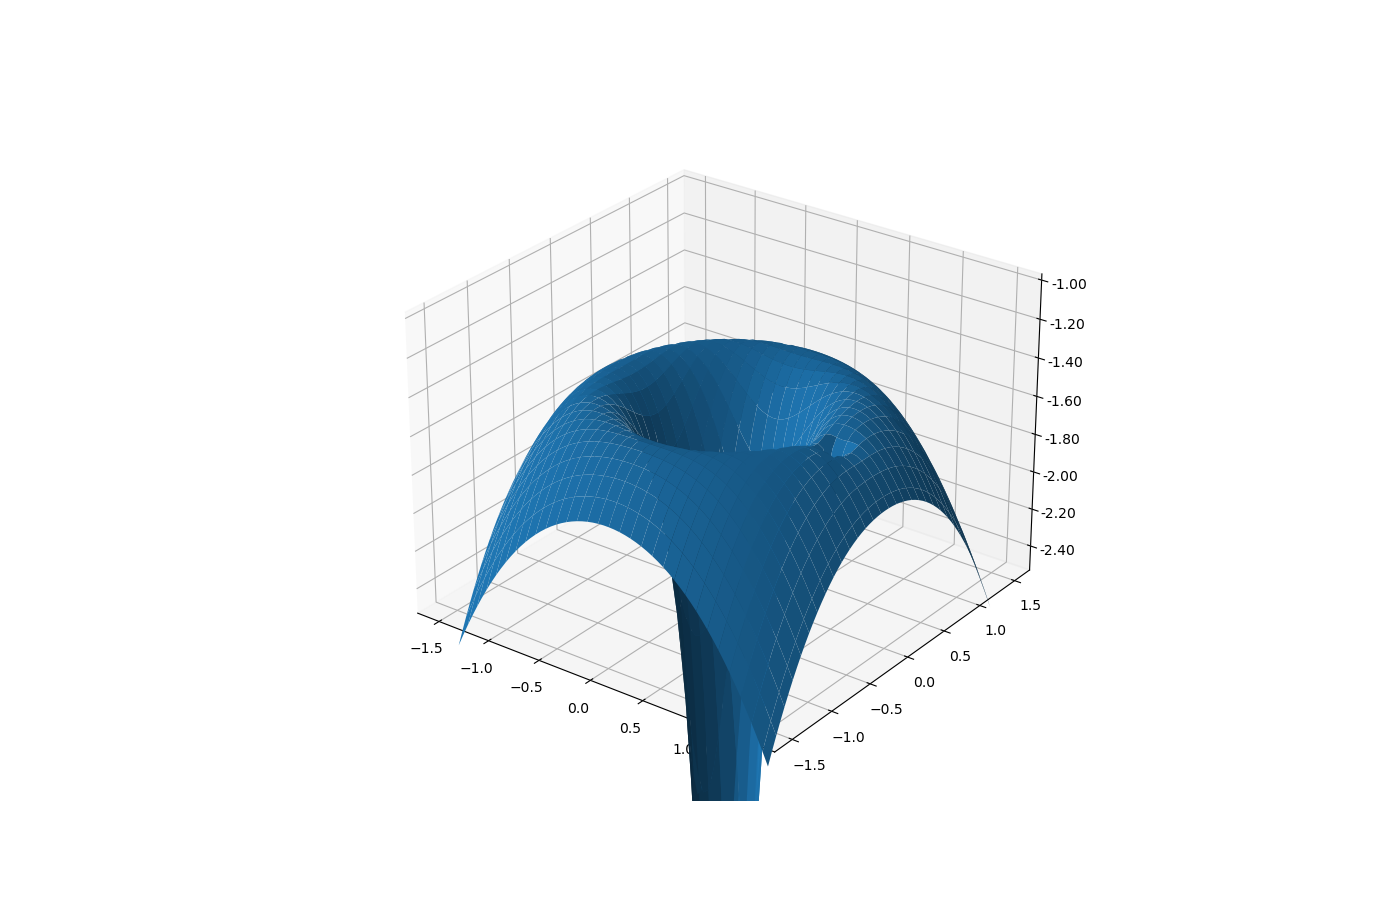

In [198]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

#left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
#ax = fig.add_axes([left, bottom, width, height]) 
#ax = plt.axes(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True)

# Customize the z axis.
ax.set_zlim(-2.5, -1)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

<IPython.core.display.Javascript object>


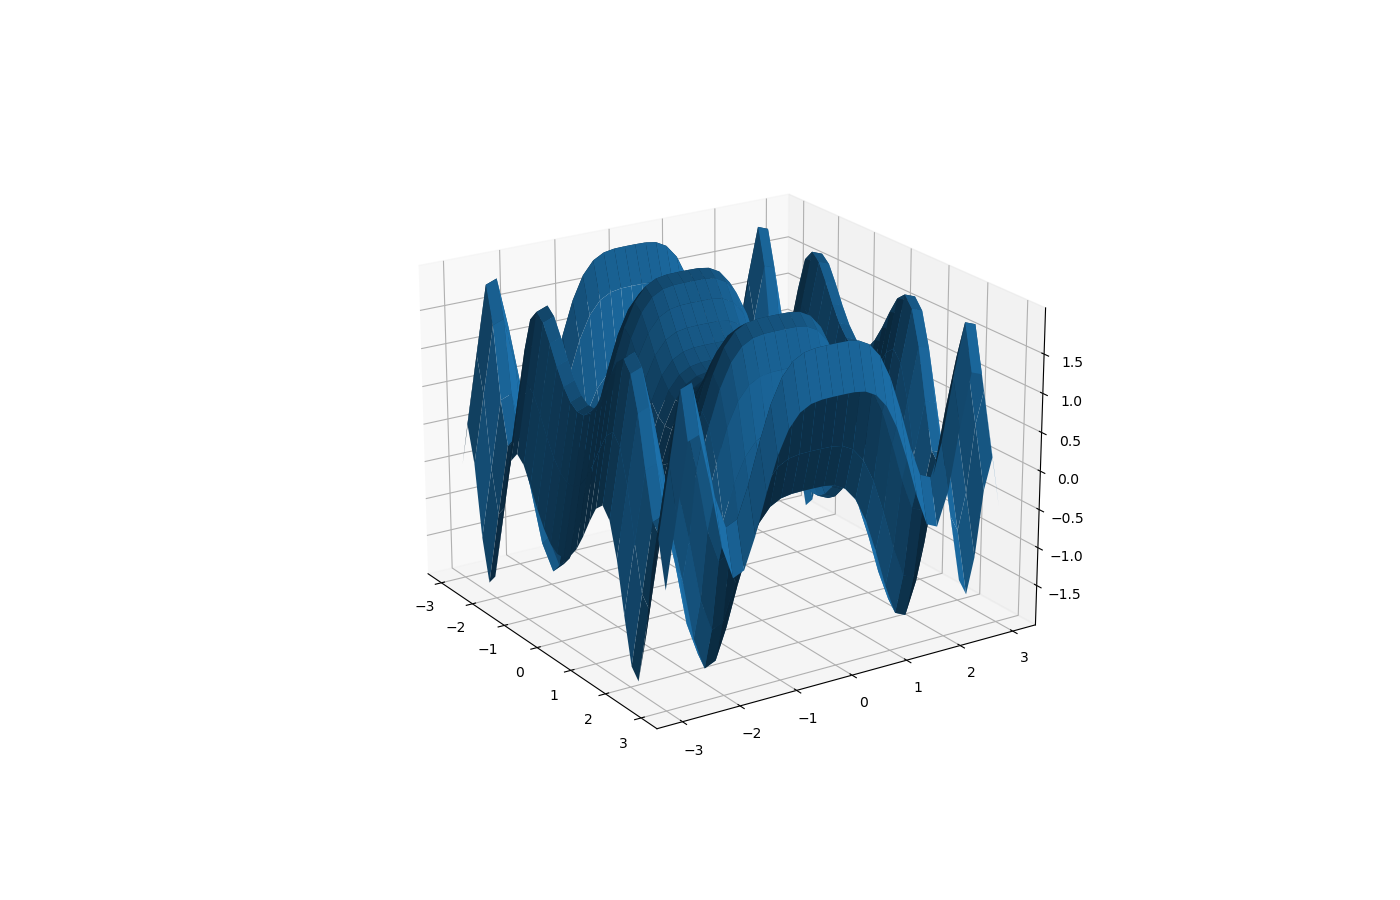

In [196]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
 
# Creating dataset
x = np.outer(np.linspace(-3, 3, 32), np.ones(32))
y = x.copy().T # transpose
z = (np.sin(x **2) + np.cos(y **2) )
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_surface(x, y, z)
 
# show plot
plt.show()